In [2]:
import os
import shutil
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Flatten, BatchNormalization, Dropout, Dense
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import cv2
import bcolz

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [14]:
path = '/home/ubuntu/hands/HandRecognition'
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
lr = 1e-7
opt = Adam(lr=lr)
batch_size = 32

In [15]:
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())
#def vgg_preprocess(x):
#    x = x - vgg_mean     # subtract mean
#    return x[:, ::-1]    # reverse axis bgr->rgb

def train_valid_split(src_dir, dest_dir = path + '/data'):
    """ This function takes a src directory and a destination directory then divides the data in the src diretory into\
    a training set and a validation set. The directory structure underneath src_dir is expected to be a directory per\
    label (i.e. '<src dir>/dogs/, <src dir>/cats/. Each label-specifie subdirectory should contain the images) """
    label = src_dir.split('/')[-1]
    filenames = os.listdir(src_dir)
    if not os.path.exists(dest_dir):
        os.mkdir(dest_dir)
    if not os.path.exists(dest_dir + '/train'):
        os.mkdir(dest_dir + '/train')
    if not os.path.exists(dest_dir + '/valid'):
        os.mkdir(dest_dir + '/valid')
    if not os.path.exists(dest_dir + '/train/' + label):
        os.mkdir(dest_dir + '/train/' + label)
    if not os.path.exists(dest_dir + '/valid/' + label):
        os.mkdir(dest_dir + '/valid/' + label)
    train, valid = train_test_split(filenames, train_size=.8)
    for filename in train:
        shutil.copyfile(src_dir + '/' + filename, dest_dir + '/train/' + label + '/' + filename)
    for filename in valid:
        shutil.copyfile(src_dir + '/' + filename, dest_dir + '/valid/' + label + '/' + filename)

In [4]:
train_valid_split(path + '/Hands')

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
train_valid_split(path + '/No_hands')

In [19]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(250,200,3))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 250, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 50, 128)       0         
__________

In [22]:
ig = ImageDataGenerator()
val_batches = ig.flow_from_directory(path + '/data/valid', shuffle=False, class_mode='categorical', batch_size=batch_size, target_size=(250,200))
trn_batches = ig.flow_from_directory(path + '/data/train', shuffle=False, class_mode='categorical', batch_size=batch_size, target_size=(250,200))
val_classes = val_batches.classes
trn_classes = trn_batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

Found 1085 images belonging to 2 classes.
Found 4673 images belonging to 2 classes.


In [23]:
val_classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [27]:
intermediate_layer_model = Model(model.input, model.get_layer('block5_pool').output)

In [28]:
trn_conv_out = intermediate_layer_model.predict_generator(trn_batches,trn_batches.samples // batch_size + 1, verbose=1)

147/147 [==============================] - 112s   


In [29]:
val_conv_out = intermediate_layer_model.predict_generator(val_batches,val_batches.samples // batch_size + 1, verbose=1)

34/34 [==============================] - 26s    


In [30]:
fc_model = Sequential([
    Flatten(input_shape=model.output_shape[1:]),
    BatchNormalization(),
    Dropout(0),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0),
    Dense(2, activation='softmax')
])

In [71]:
trn_conv_out = load_array(path + '/train_lastlayer_features.bc')
val_conv_out = load_array(path + '/val_lastlayer_features.bc')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/ubuntu/anaconda2/lib/python2.7/inspect.py", line 1049, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/ubuntu/anaconda2/lib/python2.7/inspect.py", line 1009, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/home/ubuntu/anaconda2/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File

IndexError: string index out of range

In [12]:
fc_model.load_weights('fc_weights.hd5')

In [31]:
lr = 1e-5
opt = Adam(lr=lr)
fc_model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
fc_model.fit(trn_conv_out, trn_labels, nb_epoch=32, batch_size=32, validation_data=(val_conv_out, val_labels), shuffle=True)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 4673 samples, validate on 1085 samples
Epoch 1/32
4673/4673 [==============================] - 2s - loss: 0.1175 - acc: 0.9557 - val_loss: 0.0226 - val_acc: 0.9945
Epoch 2/32
4673/4673 [==============================] - 2s - loss: 0.0143 - acc: 0.9981 - val_loss: 0.0126 - val_acc: 0.9972
Epoch 3/32
4673/4673 [==============================] - 2s - loss: 0.0060 - acc: 0.9991 - val_loss: 0.0056 - val_acc: 0.9991
Epoch 4/32
4673/4673 [==============================] - 2s - loss: 0.0042 - acc: 0.9998 - val_loss: 0.0045 - val_acc: 0.9991
Epoch 5/32
4673/4673 [==============================] - 2s - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 0.9991
Epoch 6/32
4673/4673 [==============================] - 2s - loss: 0.0031 - acc: 0.9998 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 7/32
4673/4673 [==============================] - 2s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 8/32
4673/4673 [==============================] - 2s - loss: 0.0018 - a

In [39]:
val_batches = ig.flow_from_directory(path + '/data/valid', shuffle=True, class_mode='categorical', batch_size=batch_size, target_size=(250,200))

Found 1085 images belonging to 2 classes.


In [52]:
val_batches = ig.flow_from_directory(path + '/data/kps_hands', shuffle=True, class_mode='categorical', batch_size=batch_size, target_size=(250,200))

Found 326 images belonging to 2 classes.


In [15]:
val_batches.shuffle = True

In [61]:
imgs, labels = val_batches.next()

In [33]:
final_model = Sequential()
final_model.add(model)
final_model.add(fc_model)
final_model.compile(Adam(lr=.00001), 'categorical_crossentropy', ['accuracy'])
for layer in model.layers:
    layer.trainable=False

In [34]:
final_model.save_weights('final_model.hd5')

In [36]:
final_model.save('model.hd5')

In [62]:
pred_probs = final_model.predict(imgs)

In [63]:
pred_labels = [(1,0) if p[0] > p[1] else (0,1) for p in pred_probs]

In [64]:
labels

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]], dtype=float32)

In [65]:
pred_probs

array([[  1.00000000e+00,   1.26918192e-08],
       [  5.44912552e-07,   9.99999404e-01],
       [  9.99906063e-01,   9.39781676e-05],
       [  1.00000000e+00,   1.07245688e-11],
       [  3.27037880e-04,   9.99673009e-01],
       [  1.74375671e-07,   9.99999881e-01],
       [  2.17379488e-06,   9.99997854e-01],
       [  9.99966383e-01,   3.36564408e-05],
       [  3.17861466e-03,   9.96821404e-01],
       [  1.75224147e-06,   9.99998212e-01],
       [  9.40388389e-08,   9.99999881e-01],
       [  1.00000000e+00,   2.68072144e-11],
       [  9.98328269e-01,   1.67179271e-03],
       [  1.00000000e+00,   1.65254281e-08],
       [  3.91558475e-09,   1.00000000e+00],
       [  4.74337838e-04,   9.99525666e-01],
       [  2.38664279e-06,   9.99997616e-01],
       [  1.00000000e+00,   1.55523427e-10],
       [  1.00000000e+00,   2.52348947e-10],
       [  1.00000000e+00,   9.99155533e-12],
       [  9.99996066e-01,   3.96253199e-06],
       [  1.00000000e+00,   6.14258600e-09],
       [  

In [66]:
%matplotlib inline
from matplotlib import pyplot as plt
%pylab inline

#plt.imshow(imgs[0], cmap='gray')

Populating the interactive namespace from numpy and matplotlib


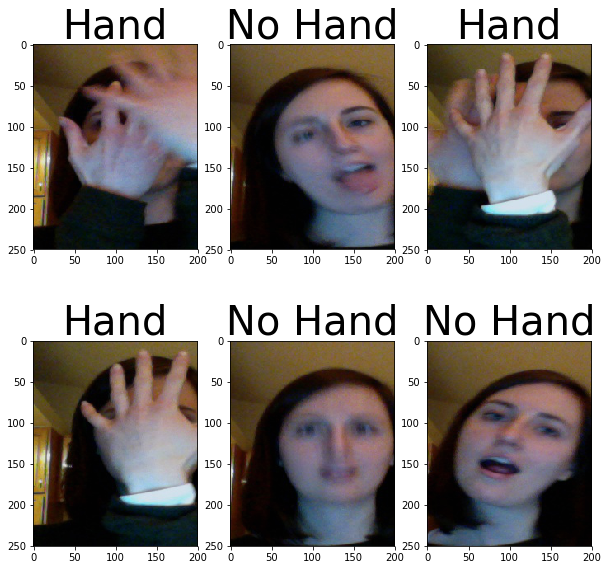

In [67]:
f, axarr = plt.subplots(2,3, figsize=(10,10))
axarr[0,0].set_title("Hand" if pred_labels[0][0] == 1 else "No Hand", fontsize=40)
axarr[0,0].imshow(255 - imgs[0])
axarr[0,1].set_title("Hand" if pred_labels[1][0] == 1 else "No Hand", fontsize=40)
axarr[0,1].imshow(255 - imgs[1])
axarr[0,2].set_title("Hand" if pred_labels[2][0] == 1 else "No Hand", fontsize=40)
axarr[0,2].imshow(255 - imgs[2])
axarr[1,0].set_title("Hand" if pred_labels[3][0] == 1 else "No Hand", fontsize=40)
axarr[1,0].imshow(255 - imgs[3])
axarr[1,1].set_title("Hand" if pred_labels[4][0] == 1 else "No Hand", fontsize=40)
axarr[1,1].imshow(255 - imgs[4])
axarr[1,2].set_title("Hand" if pred_labels[5][0] == 1 else "No Hand", fontsize=40)
axarr[1,2].imshow(255 - imgs[5])

In [ ]:
cv2.imshow('image',imgs[0])

In [18]:
fc_model.save_weights('fc_weights.hd5')

In [21]:
save_array(path + '/train_lastlayer_features.bc', trn_conv_out)
save_array(path + '/val_lastlayer_features.bc', val_conv_out)

In [24]:
labels

[(1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0)]